- move to reconciliation directory + readme.md
    - where on the grid are the old data, new data
- generate two stata files (used for Table 4)
    - v19.1

- rerun topic model
    - directly run on new data
    - deterministic
    - greedily allocate unclassified topics
    - match the new topics with the old topics: 7x7 cosine similarity matrix (old x new, find argmax of rows/cols greedily and exclusively)
    - sum the top similarities (hopefully six)
    - find the distribution of different seeds

- 0 => 0
- 1 => dtm.sum()/dtm.sum().sum()

- greedy matching the old:
    0.9 => 1-7 => excluding 1,7 col and row => 0.84 => 2-5 => 0.81 => ... => 
     score of a new topic model = mean(7 scores)

- repeat for 500+ times:
- discard !=7 topics
- find the new topic model matching the old most
- find the new topic model with highest modularity

- wordcloud
- allocate 54 words using Clustering_C

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud
seed_wc = 12345

In [2]:
def get_clusters(seed):
    random.seed(seed)
    # https://igraph.org/python/doc/api/igraph.Graph.html#Weighted_Adjacency
    graph = ig.Graph.Weighted_Adjacency(m.values, mode='undirected', attr='cosine', loops=False)
    c = graph.community_multilevel(weights='cosine')
    return c

def get_topic_vec(cluster, weight=True):
    mask = np.zeros(num_words, dtype=bool)
    mask[cluster] = True
    if not weight:
        return mask
    else:
        topic_vec = np.zeros(num_words)
        topic_vec[mask] = [word2weight[word] for word in m.columns[cluster]]
        return topic_vec
    
def get_matching_score(matrix, num_pairs=None, return_idx=False):
    
    """
    return the mean of greedily-searched best matching pairs between old and new topic vectors 
    based on max cos-similarity
    """
    
    if not num_pairs:
        num_pairs = min(matrix.shape)
        
    max_values, max_value_indices = [], []
    for _ in range(num_pairs):
        max_value_idx = np.unravel_index(np.argmax(matrix), matrix.shape)
        max_value = matrix[max_value_idx]
        max_values.append(max_value)
        matrix[max_value_idx[0], :] = -np.inf
        matrix[:, max_value_idx[1]] = -np.inf
        if return_idx:
            max_value_indices.append(max_value_idx)

    return max_values, max_value_indices

In [3]:
m = pd.read_csv("/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/cosine/cosine.csv", 
                 header=0, index_col=0)
num_words = len(m.columns)
assert num_words == 387

words = pd.read_csv('clustering_C.csv')['word'].to_list()
idx_387 = [words.index(word_387) for word_387 in m.columns]

dtmPath = '/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/concat/dtm_concatenate.npz'
dtm = sparse.load_npz(dtmPath)[:,idx_387]
weights = np.array(dtm.sum(axis=0)/dtm.sum())[0]
word2weight = {k: v for k, v in zip(m.columns, weights)}

old = pd.read_csv('clustering_C.csv')
topic_vec_old = 1 - old.pivot_table(index='word', columns='Topic').isna().loc[m.columns]

Sum of weights over all topics: 1.0000
Greedy max values of binary   : [0.944 0.907 0.897 0.851 0.823 0.82  0.386]
Greedy max values of weighted : [0.552 0.409 0.381 0.366 0.323 0.277 0.239]


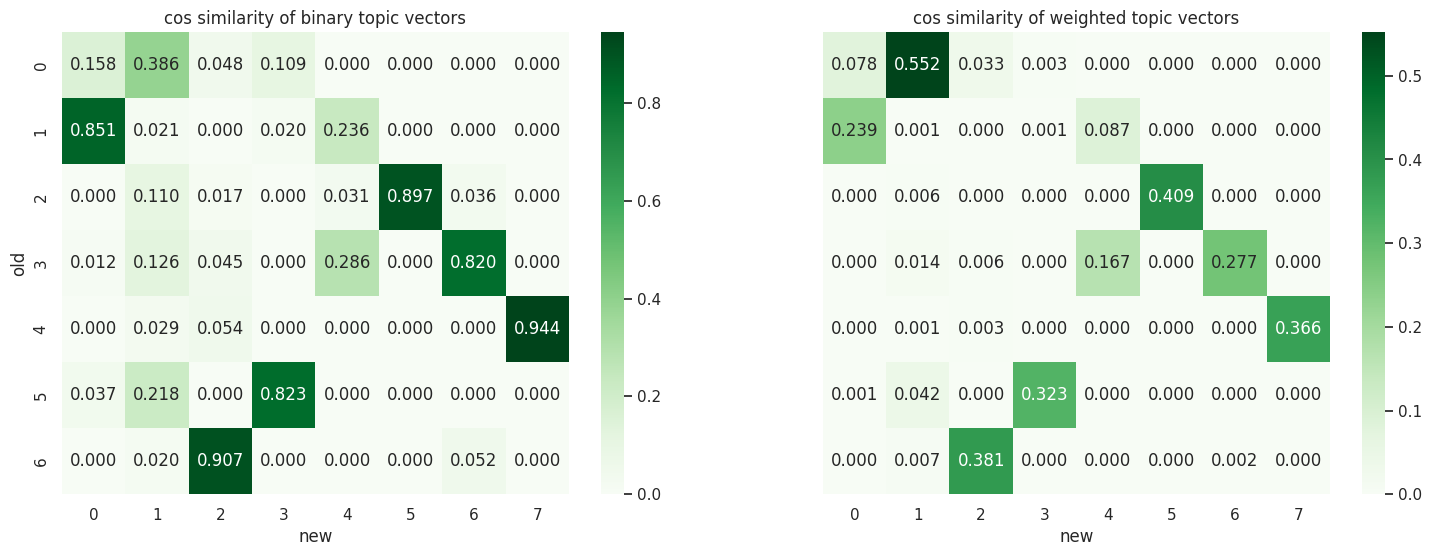

In [4]:
# sanity check: reproducibility, sum of topic vectors, greedy algo

c = get_clusters(1)
topic_vec_binary = [get_topic_vec(cluster, weight=False) for cluster in c]
topic_vec_weighted = [get_topic_vec(cluster) for cluster in c]
assert len(c.sizes()) == 8
print(f'Sum of weights over all topics: {np.sum(topic_vec_weighted):.4f}')
cs_binary = cosine_similarity(topic_vec_old.values.T, topic_vec_binary)
cs_weighted = cosine_similarity(topic_vec_old.values.T, topic_vec_weighted)

fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=2)
sns.heatmap(cs_binary, cmap='Greens', ax=ax[0], annot=True, fmt='.3f')
ax[0].set_title('cos similarity of binary topic vectors')
sns.heatmap(cs_weighted, cmap='Greens', ax=ax[1], annot=True, fmt='.3f')
ax[1].set_title('cos similarity of weighted topic vectors')
ax[1].set_yticklabels([])
ax[0].set_xlabel('new')
ax[0].set_ylabel('old')
ax[1].set_xlabel('new')

print(f'Greedy max values of binary   : {np.round(get_matching_score(cs_binary)[0],3)}')
print(f'Greedy max values of weighted : {np.round(get_matching_score(cs_weighted)[0],3)}')

100%|███████████████████████████████████████| 1234/1234 [00:50<00:00, 24.39it/s]


Occurrences of n_topics >= 8: 1009


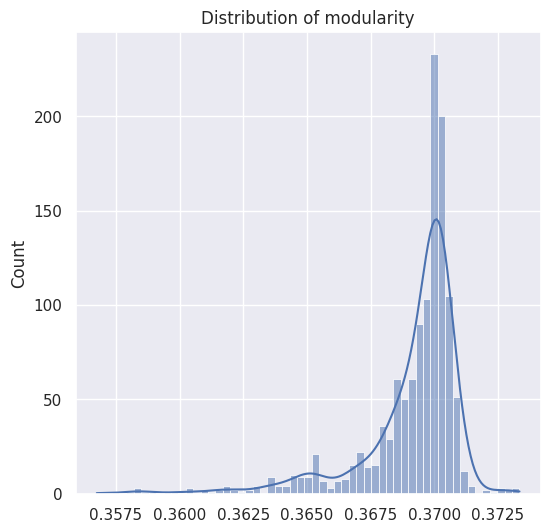

In [5]:
# sanity check: count the number of 7-topic allocations; distribution of modularity

count = 0
mod = []
cs_score = []

for s in tqdm(range(1234)):
    
    c = get_clusters(s)
    n_topics = len(c.sizes())
    mod.append(c.modularity)
    
    if n_topics == 7:
        count += 1
        
    topic_vec = [get_topic_vec(cluster) for cluster in c]
    cs = cosine_similarity(topic_vec_old.values.T, topic_vec)
    cs_score.append(np.mean(get_matching_score(cs)[0]))
    
    
print(f'Occurrences of n_topics >= 8: {count}')

seed_best_mod = int(np.argmax(mod))
seed_best_match = int(np.argmax(cs_score))

fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(mod, kde=True, ax=ax)
ax.set_title('Distribution of modularity');

In [6]:
# sanity check: reproducibility (all randomness comes from "random")
print(get_clusters(seed_best_mod).modularity)
print(mod[seed_best_mod])

0.37334712135640175
0.37334712135640175


In [7]:
var_list = ['Co', 'Gom', 'Env', 'Epg', 'Bbl', 'Rpc', 'Ep']

def plot_topic_wordclouds(word_weights, ncols=2, topic_names=var_list):
    nrows = int(np.ceil(len(word_weights)/ncols))
    fig, ax = plt.subplots(figsize=(12,24), nrows=nrows, ncols=ncols)
    for i, (w, topic) in enumerate(zip(word_weights, topic_names)):
        wordcloud = WordCloud(width = 400, height = 400,
                          background_color ='white',
                          random_state=seed_wc).generate_from_frequencies(w)
        ax[int(i/ncols)][i%ncols].imshow(wordcloud)
        ax[int(i/ncols)][i%ncols].axis('off')
        ax[int(i/ncols)][i%ncols].set_title(topic)
    
    # hide the last ax
    ax[-1, -1].set_visible(False)

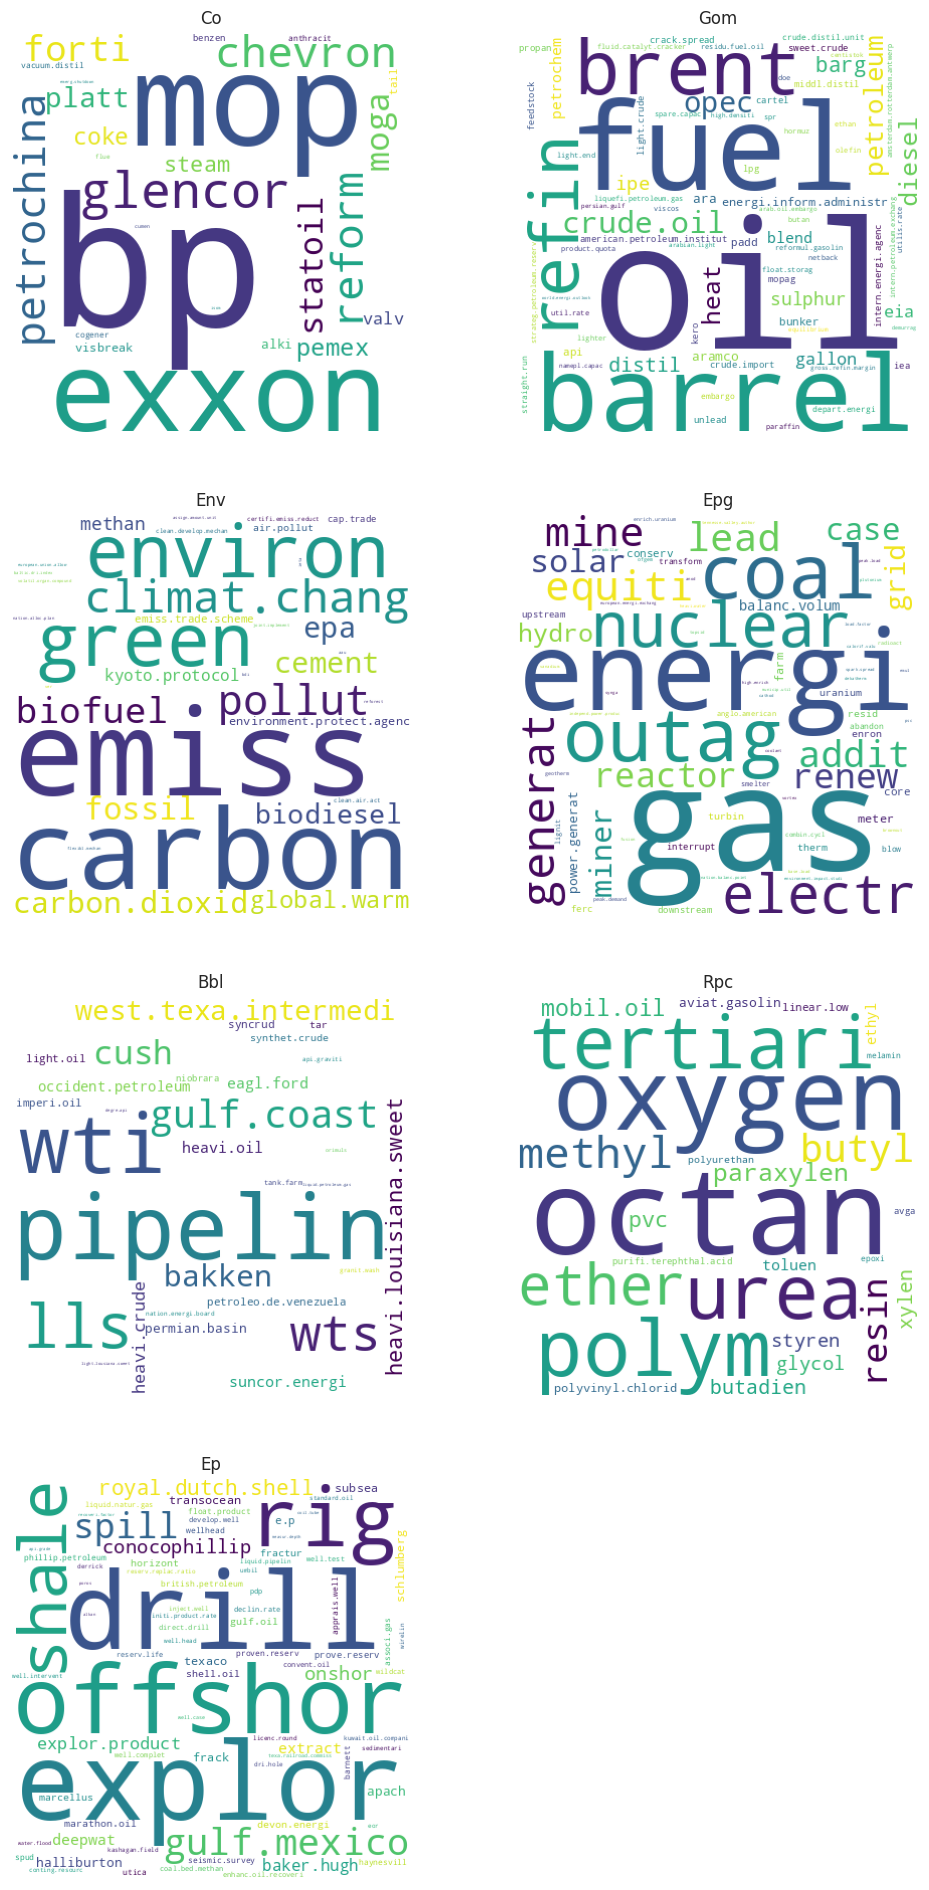

In [8]:
c = get_clusters(seed_best_match)
topic_vec = [get_topic_vec(cluster) for cluster in c]
cs = cosine_similarity(topic_vec_old.values.T, topic_vec)
_, old2new = get_matching_score(cs, return_idx=True)

assert len(old2new) == 7
word_weights = list(range(len(old2new)))
for old, new in old2new:
    word_weights[old] = {k: v for k, v in zip(m.columns, topic_vec[new])}

plot_topic_wordclouds(word_weights)
plt.savefig('clouds best match.pdf')

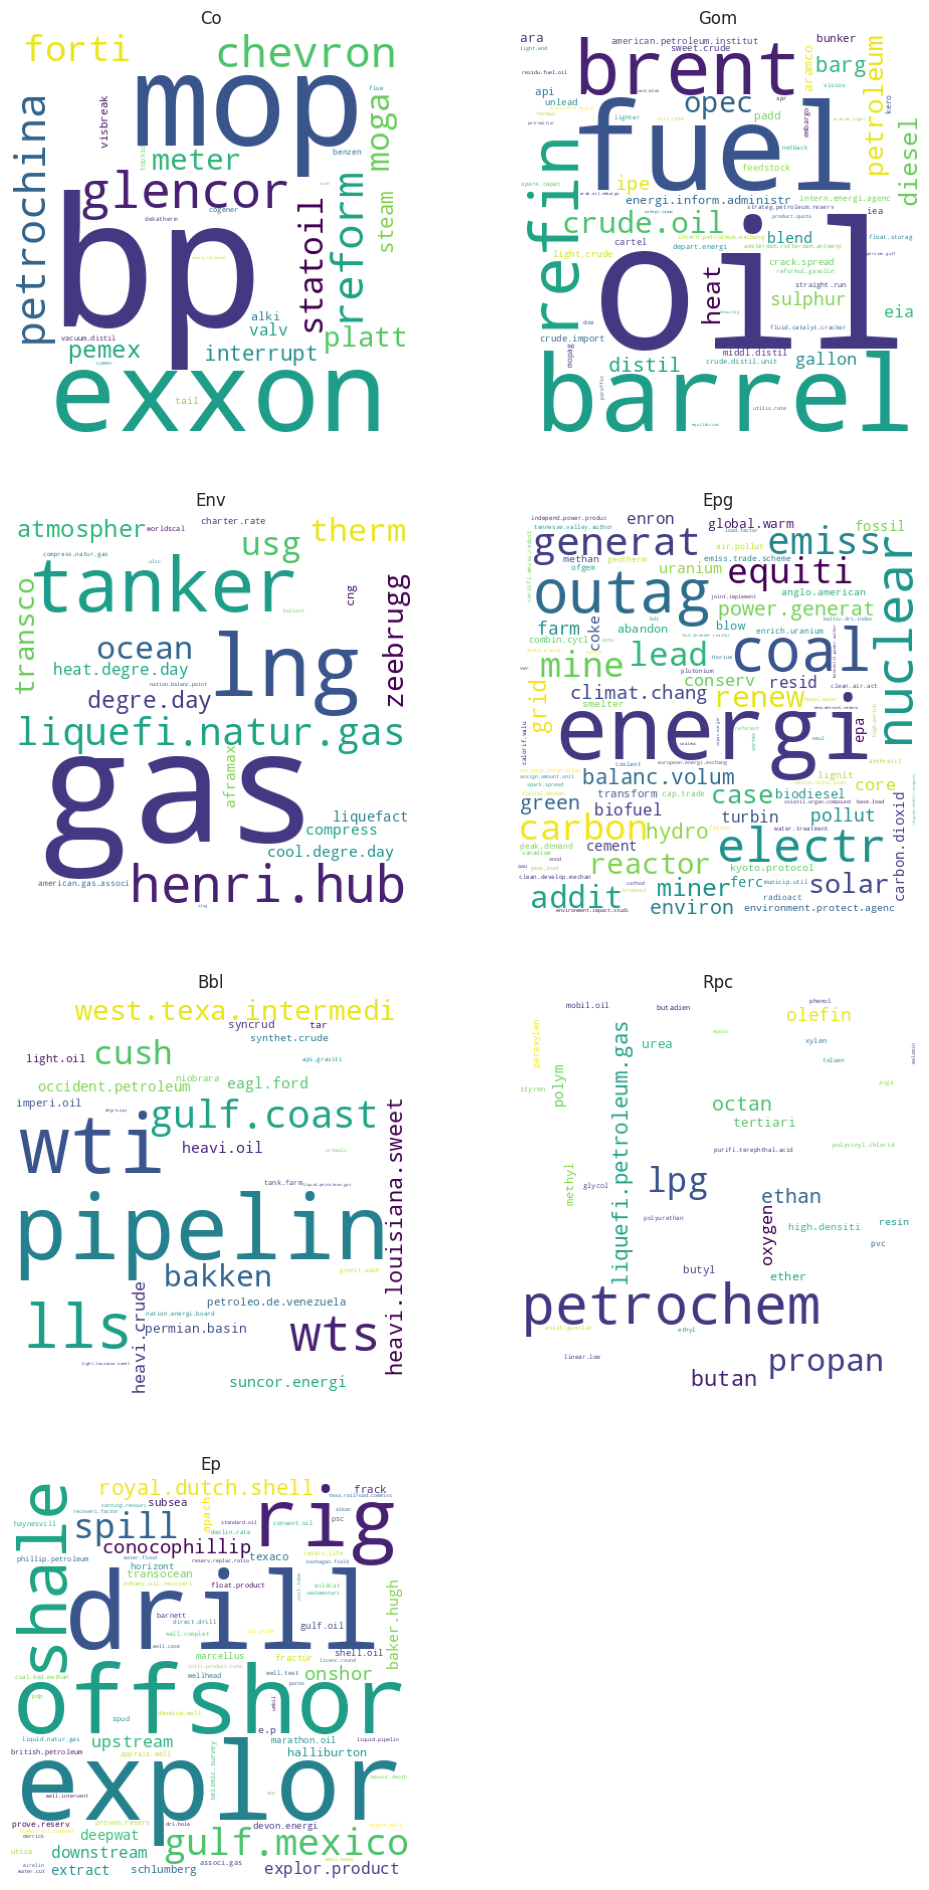

In [9]:
c = get_clusters(seed_best_mod)
topic_vec = [get_topic_vec(cluster) for cluster in c]
cs = cosine_similarity(topic_vec_old.values.T, topic_vec)
_, old2new = get_matching_score(cs, return_idx=True)

assert len(old2new) == 7
word_weights = list(range(len(old2new)))
for old, new in old2new:
    word_weights[old] = {k: v for k, v in zip(m.columns, topic_vec[new])}

plot_topic_wordclouds(word_weights)
plt.savefig('clouds best mod.pdf')